In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import os
import torch.optim as optim

In [3]:
training_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomResizedCrop(size=32, scale=(0.5, 2)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     torchvision.transforms.RandomRotation((15)),
     ])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 cat truck frog plane


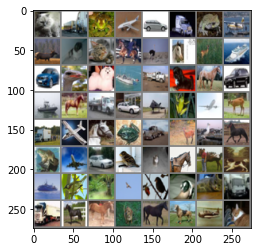

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%4s' % classes[labels[j]] for j in range(4)))


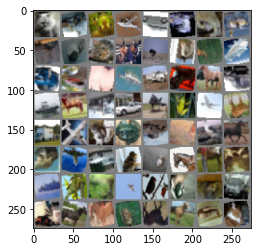

In [5]:
img_cp = images.clone()
for idx in range(len(labels)):
    img_cp[idx] = training_transform(img_cp[idx].permute(1, 2, 0).numpy())
    #imshow(torchvision.utils.make_grid(images[idx]))
    
    #print(images[idx].shape)
imshow(torchvision.utils.make_grid(img_cp))

## Using GPU to Training

In [6]:
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 2080 with Max-Q Design


# 2. Define a Convolution Neural Network



In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # input : 3 X 32 X 32
        
        #(width + pad*2 - kernel)/stride + 1
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        ## in=3, out=6, kernel=5, => (32 + 2*0 - 5)/1 + 1 = 28
        ## pool => 28 -> 14
        x = self.pool(F.relu(self.conv1(x)))
        
        ## in=3, out=6, kernel=5, => (14 + 2*0 - 5)/1 + 1 = 10
        ## pool => 10 -> 5
        x = self.pool(F.relu(self.conv2(x)))
        
        
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [8]:
net = Net().to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [9]:
class k33_Net(nn.Module):
    def __init__(self):
        super(k33_Net, self).__init__()
        # input : 3 X 32 X 32
        
        #(width + pad*2 - kernel)/stride + 1
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        ## in=3, out=6, kernel=5, => (32 + 2*0 - 5)/1 + 1 = 28
        ## pool => 28 -> 14
        x = self.pool(F.relu(self.conv1(x)))
        
        
        ## in=16, out=16, kernel=3, => (14 + 2*1 - 3)/1 + 1 = 14
        x = F.relu(self.conv2(x))
        
        
        ## in=16, out=16, kernel=3, => (14 + 2*1 - 3)/1 + 1 = 14
        x = F.relu(self.conv3(x))
        
        
        
        ## in=6, out=16, kernel=5, => (14 + 2*0 - 5)/1 + 1 = 10
        ## pool => 10 -> 5
        
        x = self.pool(F.relu(self.conv4(x)))
        
        
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
net = k33_Net().to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 14, 14]             880
            Conv2d-4           [-1, 16, 14, 14]           2,320
            Conv2d-5           [-1, 16, 10, 10]           6,416
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 69,206
Trainable params: 69,206
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.26
Estimated Total Size (MB): 0.39
---------------------------------------------

In [11]:
class k33_fat_Net(nn.Module):
    def __init__(self):
        super(k33_fat_Net, self).__init__()
        # input : 3 X 32 X 32
        
        #(width + pad*2 - kernel)/stride + 1
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        ## in=3, out=6, kernel=5, => (32 + 2*0 - 5)/1 + 1 = 28
        ## pool => 28 -> 14
        x = self.pool(F.relu(self.conv1(x)))
        
        
        ## in=6, out=16, kernel=3, => (14 + 2*1 - 3)/1 + 1 = 14
        x = F.relu(self.conv2(x))
        
        
        ## in=16, out=64, kernel=3, => (14 + 2*1 - 3)/1 + 1 = 14
        x = F.relu(self.conv3(x))
        
        
        
        ## in=64, out=32, kernel=5, => (14 + 2*0 - 5)/1 + 1 = 10
        ## pool => 10 -> 5        
        x = self.pool(F.relu(self.conv4(x)))
        
        
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
net = k33_fat_Net().to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 14, 14]             880
            Conv2d-4           [-1, 64, 14, 14]           9,280
            Conv2d-5           [-1, 32, 10, 10]          51,232
         MaxPool2d-6             [-1, 32, 5, 5]               0
            Linear-7                  [-1, 120]          96,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 168,982
Trainable params: 168,982
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.20
Params size (MB): 0.64
Estimated Total Size (MB): 0.85
-------------------------------------------

In [13]:
class my_Net(nn.Module):
    def __init__(self):
        super(my_Net, self).__init__()
        # input : 3 X 32 X 32
        
        #(width + pad*2 - kernel)/stride + 1
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            
            nn.Conv2d(128, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 128),
            nn.Linear(128, 10),
        )
        

    def forward(self, input):
        return self.main(input)

In [14]:
net = my_Net().to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,456
       BatchNorm2d-2          [-1, 128, 32, 32]             256
         LeakyReLU-3          [-1, 128, 32, 32]               0
         MaxPool2d-4          [-1, 128, 16, 16]               0
           Dropout-5          [-1, 128, 16, 16]               0
            Conv2d-6          [-1, 256, 16, 16]         294,912
       BatchNorm2d-7          [-1, 256, 16, 16]             512
         LeakyReLU-8          [-1, 256, 16, 16]               0
         MaxPool2d-9            [-1, 256, 8, 8]               0
          Dropout-10            [-1, 256, 8, 8]               0
           Conv2d-11            [-1, 512, 8, 8]       1,179,648
      BatchNorm2d-12            [-1, 512, 8, 8]           1,024
        LeakyReLU-13            [-1, 512, 8, 8]               0
           Conv2d-14            [-1, 51

# 3. Define a Loss function and optimizer




In [15]:
def weights_reset(m):
    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [16]:
# # Tenserboard
# import shutil
# log_dir = './log_hw0'

# if os.path.isdir(log_dir):
#     shutil.rmtree(log_dir)

# # if not os.path.isdir(log_dir):
# #     os.makedirs(log_dir)
    
# print(os.path.isdir(log_dir))


In [17]:
# os.makedirs(log_dir)

In [18]:
def test_part(net, test_loader):
    
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()

    print('\n\tAccuracy of the network on the 10000 test images: %.3f %%' % (100 * correct / total))
    
    

In [19]:
def train_part(net, criterion, optimizer, epochs, add_data=True):
    # writer = SummaryWriter(log_dir)
    iters = 0
    for epoch in range(epochs):  # loop over the dataset multiple times

        mean_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            net.train()    

            # get the inputs
            inputs, labels = data[0], data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            inputs_cp = inputs.detach().clone()
            if add_data:
                for idx in range(len(labels)):
                    inputs_cp[idx] = training_transform(inputs_cp[idx].permute(1, 2, 0).numpy())
            
            outputs = net(inputs_cp.to(device))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            if i == 0:
                print(f"\nEpoch:{epoch+1}")
            mean_loss += loss.item()
            
            print(f"\r\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.3f}, MeanLoss:{mean_loss/(i+1):.3f}", end='')
            
            #writer.add_scalar('Loss', loss.item(), iters)

            iters += 1
        test_part(net, testloader)

In [20]:
def choise_net(Net):
    net = Net().to(device)
    return net

In [25]:
def choise_optim(Net, opt):
    
    if (opt == 'sgd'):
        return optim.SGD(Net.parameters(), lr=0.001, momentum=0.9)
    elif (opt == 'adam'):
        return optim.Adam(Net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    elif (opt == 'rms'):
        return optim.RMSprop(Net.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    elif (opt == 'adamW'):
        return optim.AdamW(Net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,)

In [26]:
CrossEntropy = nn.CrossEntropyLoss()

# 4. Train the network






## original model(sgd)

In [333]:
net = choise_net(Net) #original model
net.apply(weights_reset)
Optim = choise_optim(net, 'sgd')

train_part(net, CrossEntropy, Optim, 10, False)


Epoch:1
	Batch:782 of 782, loss:2.281, MeanLoss:2.300
	Accuracy of the network on the 10000 test images: 14.680 %

Epoch:2
	Batch:782 of 782, loss:2.025, MeanLoss:2.213
	Accuracy of the network on the 10000 test images: 23.930 %

Epoch:3
	Batch:782 of 782, loss:2.087, MeanLoss:2.064
	Accuracy of the network on the 10000 test images: 28.290 %

Epoch:4
	Batch:782 of 782, loss:1.930, MeanLoss:1.917
	Accuracy of the network on the 10000 test images: 34.150 %

Epoch:5
	Batch:782 of 782, loss:1.527, MeanLoss:1.699
	Accuracy of the network on the 10000 test images: 41.800 %

Epoch:6
	Batch:782 of 782, loss:1.604, MeanLoss:1.573
	Accuracy of the network on the 10000 test images: 44.590 %

Epoch:7
	Batch:782 of 782, loss:1.726, MeanLoss:1.509
	Accuracy of the network on the 10000 test images: 46.620 %

Epoch:8
	Batch:782 of 782, loss:1.175, MeanLoss:1.453
	Accuracy of the network on the 10000 test images: 48.720 %

Epoch:9
	Batch:782 of 782, loss:1.460, MeanLoss:1.407
	Accuracy of the network 

## original model(adam)

In [321]:
net = choise_net(Net) #original model
net.apply(weights_reset)
Optim = choise_optim(net, 'adam')

train_part(net, CrossEntropy, Optim, 10, False)


Epoch:1
	Batch:782 of 782, loss:1.741, MeanLoss:1.666
	Accuracy of the network on the 10000 test images: 47.610 %

Epoch:2
	Batch:782 of 782, loss:1.338, MeanLoss:1.368
	Accuracy of the network on the 10000 test images: 51.610 %

Epoch:3
	Batch:782 of 782, loss:0.892, MeanLoss:1.237
	Accuracy of the network on the 10000 test images: 57.040 %

Epoch:4
	Batch:782 of 782, loss:1.629, MeanLoss:1.152
	Accuracy of the network on the 10000 test images: 58.900 %

Epoch:5
	Batch:782 of 782, loss:1.077, MeanLoss:1.090
	Accuracy of the network on the 10000 test images: 60.210 %

Epoch:6
	Batch:782 of 782, loss:0.821, MeanLoss:1.035
	Accuracy of the network on the 10000 test images: 60.560 %

Epoch:7
	Batch:782 of 782, loss:0.637, MeanLoss:0.993
	Accuracy of the network on the 10000 test images: 61.520 %

Epoch:8
	Batch:782 of 782, loss:1.310, MeanLoss:0.952
	Accuracy of the network on the 10000 test images: 61.630 %

Epoch:9
	Batch:782 of 782, loss:0.883, MeanLoss:0.915
	Accuracy of the network 

## original model(rms)

In [322]:
net = choise_net(Net) #original model
net.apply(weights_reset)
Optim = choise_optim(net, 'rms')

train_part(net, CrossEntropy, Optim, 10, False)


Epoch:1
	Batch:782 of 782, loss:1.964, MeanLoss:2.6599711
	Accuracy of the network on the 10000 test images: 27.190 %

Epoch:2
	Batch:782 of 782, loss:1.629, MeanLoss:1.814
	Accuracy of the network on the 10000 test images: 32.000 %

Epoch:3
	Batch:782 of 782, loss:1.790, MeanLoss:1.692
	Accuracy of the network on the 10000 test images: 37.580 %

Epoch:4
	Batch:782 of 782, loss:1.718, MeanLoss:1.607
	Accuracy of the network on the 10000 test images: 30.720 %

Epoch:5
	Batch:782 of 782, loss:1.626, MeanLoss:1.545
	Accuracy of the network on the 10000 test images: 37.900 %

Epoch:6
	Batch:782 of 782, loss:1.265, MeanLoss:1.511
	Accuracy of the network on the 10000 test images: 45.950 %

Epoch:7
	Batch:782 of 782, loss:1.062, MeanLoss:1.470
	Accuracy of the network on the 10000 test images: 41.700 %

Epoch:8
	Batch:782 of 782, loss:1.276, MeanLoss:1.448
	Accuracy of the network on the 10000 test images: 49.880 %

Epoch:9
	Batch:782 of 782, loss:1.373, MeanLoss:1.425
	Accuracy of the netw

## kernel(3, 3) model

In [29]:
net = choise_net(k33_Net) #original model
net.apply(weights_reset)
SGD = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_part(net, CrossEntropy, SGD, 40)


Epoch:1
	Batch:782 of 782, loss:2.300
	Accuracy of the network on the 10000 test images: 10 %

Epoch:2
	Batch:782 of 782, loss:2.299
	Accuracy of the network on the 10000 test images: 13 %

Epoch:3
	Batch:782 of 782, loss:2.303
	Accuracy of the network on the 10000 test images: 15 %

Epoch:4
	Batch:782 of 782, loss:1.977
	Accuracy of the network on the 10000 test images: 19 %

Epoch:5
	Batch:782 of 782, loss:1.849
	Accuracy of the network on the 10000 test images: 34 %

Epoch:6
	Batch:782 of 782, loss:1.512
	Accuracy of the network on the 10000 test images: 38 %

Epoch:7
	Batch:782 of 782, loss:1.519
	Accuracy of the network on the 10000 test images: 41 %

Epoch:8
	Batch:782 of 782, loss:1.270
	Accuracy of the network on the 10000 test images: 42 %

Epoch:9
	Batch:782 of 782, loss:1.182
	Accuracy of the network on the 10000 test images: 45 %

Epoch:10
	Batch:782 of 782, loss:1.473
	Accuracy of the network on the 10000 test images: 47 %

Epoch:11
	Batch:782 of 782, loss:1.069
	Accuracy

## fat k(3,3) net

In [57]:
net = choise_net(k33_fat_Net) #original model
net.apply(weights_reset)
Optim = choise_optim(net, 'sgd')

train_part(net, CrossEntropy, Optim, 40)


Epoch:1
	Batch:782 of 782, loss:2.308
	Accuracy of the network on the 10000 test images: 10 %

Epoch:2
	Batch:782 of 782, loss:2.299
	Accuracy of the network on the 10000 test images: 15 %

Epoch:3
	Batch:782 of 782, loss:2.046
	Accuracy of the network on the 10000 test images: 22 %

Epoch:4
	Batch:782 of 782, loss:1.830
	Accuracy of the network on the 10000 test images: 30 %

Epoch:5
	Batch:782 of 782, loss:1.705
	Accuracy of the network on the 10000 test images: 35 %

Epoch:6
	Batch:782 of 782, loss:1.665
	Accuracy of the network on the 10000 test images: 38 %

Epoch:7
	Batch:782 of 782, loss:1.605
	Accuracy of the network on the 10000 test images: 44 %

Epoch:8
	Batch:782 of 782, loss:1.406
	Accuracy of the network on the 10000 test images: 45 %

Epoch:9
	Batch:782 of 782, loss:1.664
	Accuracy of the network on the 10000 test images: 47 %

Epoch:10
	Batch:782 of 782, loss:1.322
	Accuracy of the network on the 10000 test images: 49 %

Epoch:11
	Batch:782 of 782, loss:1.217
	Accuracy

## my_Net(just modify model)

In [332]:
net = choise_net(my_Net) #original model
net.apply(weights_reset)
Optim = choise_optim(net, 'adam')

train_part(net, CrossEntropy, Optim, 100, False)


Epoch:1
	Batch:782 of 782, loss:0.912, MeanLoss:1.446
	Accuracy of the network on the 10000 test images: 58.420 %

Epoch:2
	Batch:782 of 782, loss:0.670, MeanLoss:1.035
	Accuracy of the network on the 10000 test images: 65.180 %

Epoch:3
	Batch:782 of 782, loss:0.843, MeanLoss:0.869
	Accuracy of the network on the 10000 test images: 72.470 %

Epoch:4
	Batch:782 of 782, loss:0.826, MeanLoss:0.758
	Accuracy of the network on the 10000 test images: 76.170 %

Epoch:5
	Batch:782 of 782, loss:0.694, MeanLoss:0.681
	Accuracy of the network on the 10000 test images: 75.820 %

Epoch:6
	Batch:782 of 782, loss:0.598, MeanLoss:0.616
	Accuracy of the network on the 10000 test images: 77.180 %

Epoch:7
	Batch:782 of 782, loss:0.255, MeanLoss:0.557
	Accuracy of the network on the 10000 test images: 76.710 %

Epoch:8
	Batch:782 of 782, loss:0.446, MeanLoss:0.512
	Accuracy of the network on the 10000 test images: 79.850 %

Epoch:9
	Batch:782 of 782, loss:0.661, MeanLoss:0.471
	Accuracy of the network 

## my_Net(modify model & Data Augmentation)

In [328]:
net2 = choise_net(my_Net) #original model
net2.apply(weights_reset)
Optim = choise_optim(net2, 'adam')

train_part(net2, CrossEntropy, Optim, 150)


Epoch:1
	Batch:782 of 782, loss:1.861, MeanLoss:1.808
	Accuracy of the network on the 10000 test images: 41.750 %

Epoch:2
	Batch:782 of 782, loss:1.955, MeanLoss:1.576
	Accuracy of the network on the 10000 test images: 46.340 %

Epoch:3
	Batch:782 of 782, loss:1.512, MeanLoss:1.451
	Accuracy of the network on the 10000 test images: 55.420 %

Epoch:4
	Batch:782 of 782, loss:1.055, MeanLoss:1.345
	Accuracy of the network on the 10000 test images: 51.340 %

Epoch:5
	Batch:782 of 782, loss:1.243, MeanLoss:1.277
	Accuracy of the network on the 10000 test images: 57.790 %

Epoch:6
	Batch:782 of 782, loss:1.020, MeanLoss:1.206
	Accuracy of the network on the 10000 test images: 59.870 %

Epoch:7
	Batch:782 of 782, loss:1.099, MeanLoss:1.147
	Accuracy of the network on the 10000 test images: 65.100 %

Epoch:8
	Batch:782 of 782, loss:1.288, MeanLoss:1.100
	Accuracy of the network on the 10000 test images: 66.790 %

Epoch:9
	Batch:782 of 782, loss:0.907, MeanLoss:1.060
	Accuracy of the network 

## my_Net(150 epochs, adamW)

In [27]:
net4 = choise_net(my_Net) 
net4.apply(weights_reset)
Optim = choise_optim(net4, 'adamW')

train_part(net4, CrossEntropy, Optim, 150)


Epoch:1
	Batch:782 of 782, loss:1.378, MeanLoss:1.821
	Accuracy of the network on the 10000 test images: 40.100 %

Epoch:2
	Batch:782 of 782, loss:1.643, MeanLoss:1.577
	Accuracy of the network on the 10000 test images: 50.070 %

Epoch:3
	Batch:782 of 782, loss:1.452, MeanLoss:1.454
	Accuracy of the network on the 10000 test images: 47.830 %

Epoch:4
	Batch:782 of 782, loss:1.294, MeanLoss:1.361
	Accuracy of the network on the 10000 test images: 55.730 %

Epoch:5
	Batch:782 of 782, loss:1.489, MeanLoss:1.284
	Accuracy of the network on the 10000 test images: 58.220 %

Epoch:6
	Batch:782 of 782, loss:1.025, MeanLoss:1.227
	Accuracy of the network on the 10000 test images: 59.320 %

Epoch:7
	Batch:782 of 782, loss:1.919, MeanLoss:1.158
	Accuracy of the network on the 10000 test images: 65.440 %

Epoch:8
	Batch:782 of 782, loss:0.786, MeanLoss:1.117
	Accuracy of the network on the 10000 test images: 66.050 %

Epoch:9
	Batch:782 of 782, loss:0.899, MeanLoss:1.074
	Accuracy of the network 

## my_Net(modify model & Data Augmentation) --> 400 epochs

In [24]:
net3 = choise_net(my_Net) #original model
net3.apply(weights_reset)
Optim = choise_optim(net3, 'adam')

train_part(net3, CrossEntropy, Optim, 400)


Epoch:1
	Batch:782 of 782, loss:1.557, MeanLoss:1.797
	Accuracy of the network on the 10000 test images: 40.550 %

Epoch:2
	Batch:782 of 782, loss:1.504, MeanLoss:1.565
	Accuracy of the network on the 10000 test images: 45.920 %

Epoch:3
	Batch:782 of 782, loss:1.768, MeanLoss:1.427
	Accuracy of the network on the 10000 test images: 56.370 %

Epoch:4
	Batch:782 of 782, loss:1.638, MeanLoss:1.345
	Accuracy of the network on the 10000 test images: 56.630 %

Epoch:5
	Batch:782 of 782, loss:1.095, MeanLoss:1.268
	Accuracy of the network on the 10000 test images: 62.520 %

Epoch:6
	Batch:782 of 782, loss:1.251, MeanLoss:1.204
	Accuracy of the network on the 10000 test images: 57.840 %

Epoch:7
	Batch:782 of 782, loss:0.956, MeanLoss:1.148
	Accuracy of the network on the 10000 test images: 65.890 %

Epoch:8
	Batch:782 of 782, loss:1.048, MeanLoss:1.104
	Accuracy of the network on the 10000 test images: 64.990 %

Epoch:9
	Batch:782 of 782, loss:1.169, MeanLoss:1.070
	Accuracy of the network 

# show result

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
preds = np.zeros((1))
truth = np.zeros((1))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.numpy()], axis=0)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Display the confusion matrix as a heatmap

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
class_names = ['plane', 'car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")

Some multi-class performance report defined from Scikit-learn

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(truth, preds, target_names=class_names))